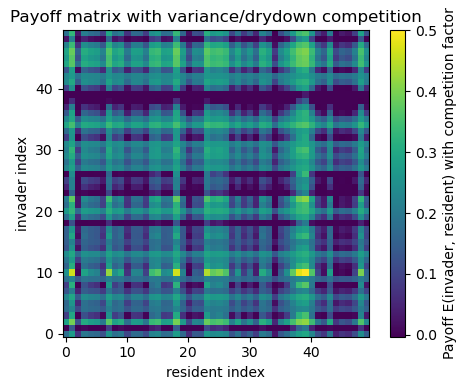

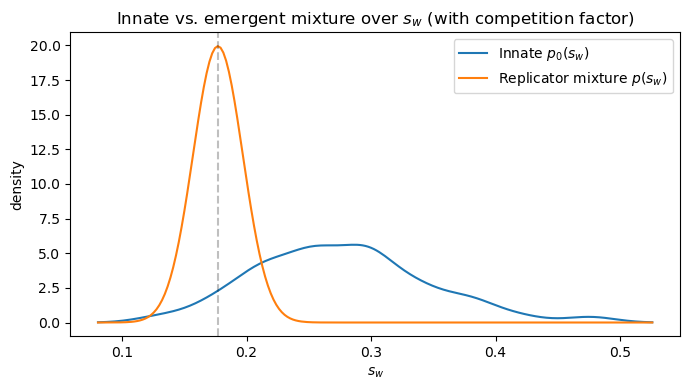

Payoff matrix shape: (50, 50)
Resident setpoints (s_hat) example: [0.37397422 0.44857472 0.31272646 0.38376744 0.37108073]
Replicator stationary mixture (first 5 weights): [2.77234519e-205 0.00000000e+000 2.52076978e-130 0.00000000e+000
 2.27727757e-105]
ESS indices: [34]
Mean emergent s_w: 0.17704355932588886


In [1]:

import numpy as np
from owus_ess_competition import run_owus_ess, ESSConfig

# --- 1. Fake OWUS posterior draws (to replace with real ones later) ---
rng = np.random.default_rng(42)
N = 50  # number of posterior samples (strategies)

fww   = np.clip(rng.normal(0.60, 0.07, N), 0.3, 0.95)
sstar = np.clip(rng.normal(0.45, 0.06, N), 0.2, 0.85)
sw    = np.clip(rng.normal(0.28, 0.07, N), 0.02, 0.58)
sw    = np.minimum(sw, sstar - 1e-3)  # enforce sw < s*

# --- 2. Environment statistics (variance, drydown speed) ---
# Pass scalars (applied to all residents) or arrays of length N.
sigma_s = 0.08   # soil moisture variance
kappa   = 0.5    # drydown speed

# --- 3. ESS configuration ---
cfg = ESSConfig(
    I=0.35,       # recharge-like target
    eta_var=1.2,  # strength of variance penalty
    xi_kappa=0.8, # scaling by drydown speed
    mu=0.0        # mutation smoothing off (set >0 to blur)
)

# --- 4. Run the ESS analysis ---
out = run_owus_ess(fww, sstar, sw, cfg,
                   sigma_s=sigma_s, kappa=kappa,
                   make_plots=True)

E, s_hat, p, ess_idx = out["E"], out["s_hat"], out["p"], out["ess_idx"]

# --- 5. Print summary ---
print("Payoff matrix shape:", E.shape)
print("Resident setpoints (s_hat) example:", s_hat[:5])
print("Replicator stationary mixture (first 5 weights):", p[:5])
print("ESS indices:", ess_idx)
print("Mean emergent s_w:", float((p * sw).sum()))


# OWUS ESS Model with Competition Factor

## 1. Strategy definition (from OWUS posterior)

Each strategy $x$ is defined by three OWUS parameters:

- $f_{ww}$: well-watered transpiration fraction (plateau of stress curve)
- $s^*$: soil saturation where down-regulation begins
- $s_w$: soil saturation at which transpiration ceases (shut-off point)

---

## 2. Stress response function $\beta(s)$

The OWUS stress curve is piecewise:
$$
\beta_x(s)=
\begin{cases}
0, & s \le s_w \\\\
f_{ww}\,\dfrac{s - s_w}{s^* - s_w}, & s_w < s \le s^* \\\\
f_{ww}, & s > s^*
\end{cases}
$$

- $\beta(s)$ scales potential transpiration $E_0$.
- We use $\beta(s)$ to define the environment setpoint (next section).

---

## 3. Resident environment

Following Zea-Cabrera et al. (2006), the resident strategy $x$ defines the environment via a setpoint $\hat s_R$ that solves
$$
\beta_R(\hat s_R) = I,
$$
where $I$ is a constant representing mean recharge or evaporative demand.

- If $I \le 0$, then $\hat s_R = 0$.
- If $I \ge f_{ww,R}$, then $\hat s_R = 1$.
- Otherwise solve by bisection on $[0,1]$.

---

## 4. Invader relative growth rate (RGR)

Invader growth at soil saturation $s$:
$$
\mathrm{RGR}_y(s) \;=\; a_y \,\frac{(s - s_{w,y})_+}{k_y + (s - s_{w,y})_+} \;-\; b,
$$
with $(z)_+ = \max(z,0)$ and mappings from OWUS:
$$
a_y = \alpha_a\, f_{ww,y}, \qquad
k_y = \alpha_k\, (s^*_y - s_{w,y}).
$$

Given resident $i$ and invader $j$,
$$
E(j,i) \;=\; \mathrm{RGR}_j(\hat s_i).
$$

---

## 5. Competition factor (variance + drydown speed)

Penalize strategies vulnerable in variable or fast-drying conditions:
$$
CF(j \mid i) \;=\; \max\!\Big(0,\; 1 - \eta_{\mathrm{var}} \, H(j \mid i)\Big),
$$
where
$$
H(j \mid i) \;=\; \Phi\!\left(\frac{s_{w,j} - \mu_i}{\sigma_i}\right)\,\big(1 + \xi_\kappa \, \kappa_i\big).
$$

Here $\Phi$ is the standard normal CDF, $\mu_i \approx \hat s_i$ (resident mean), $\sigma_i$ is soil-moisture std, $\kappa_i$ is drydown speed, and $\eta_{\mathrm{var}}, \xi_\kappa$ are penalty strengths.

---

## 6. Combined payoff

$$
E(j,i) \;=\; \mathrm{RGR}_j(\hat s_i)\,\times\, CF(j \mid i).
$$

---

## 7. ESS condition

A strategy $x$ is an ESS if
$$
E(x,x) \;>\; E(y,x) \quad \forall\, y \neq x.
$$

---

## 8. Replicator dynamics

For population distribution $p(t)$ over strategies:
$$
p_j(t+1) \;=\; \frac{p_j(t)\;\sum_i p_i(t)\,E(j,i)}{\sum_k p_k(t)\sum_i p_i(t)\,E(k,i)}.
$$

With mutation/diffusion (optional) using a kernel $K$ and rate $\mu$:
$$
p(t+1) \;=\; (1-\mu)\,p'(t) \;+\; \mu\,K\,p'(t).
$$

---

## 9. Outputs to analyze

- Payoff matrix $E(j,i)$
- ESS indices (those $x$ with $E(x,x) > E(y,x)$ for all $y$)
- Stationary distribution $p^*$ from replicator dynamics
- Induced distribution of $s_w$ under $p^*$


The posterior = uncertainty about possible traits (data-driven).

The ESS distribution = evolutionary prediction of which subset/mix is viable and stable (game-theoretic).

The ESS distribution can be interpreted as the “realized distribution of strategies” at the ecosystem/pixel scale (i.e., stable trait ensemble).

Width comparison (bigger = wider spread)
  Spatial iso-index:    std=125.373, IQR=3.322
  Temporal iso-fraction: std=0.152, IQR=0.324
  ==> Spatial distribution is wider by std.
  ==> Spatial distribution is wider by IQR.


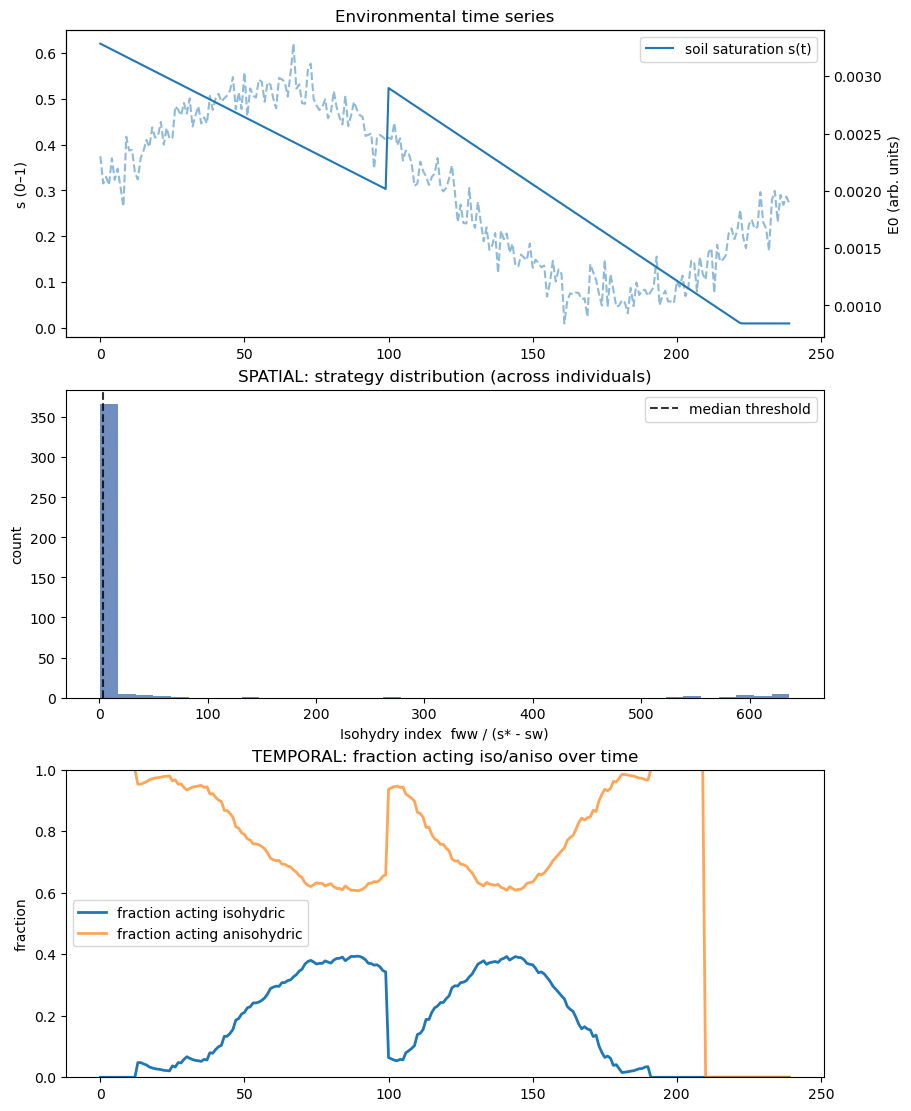

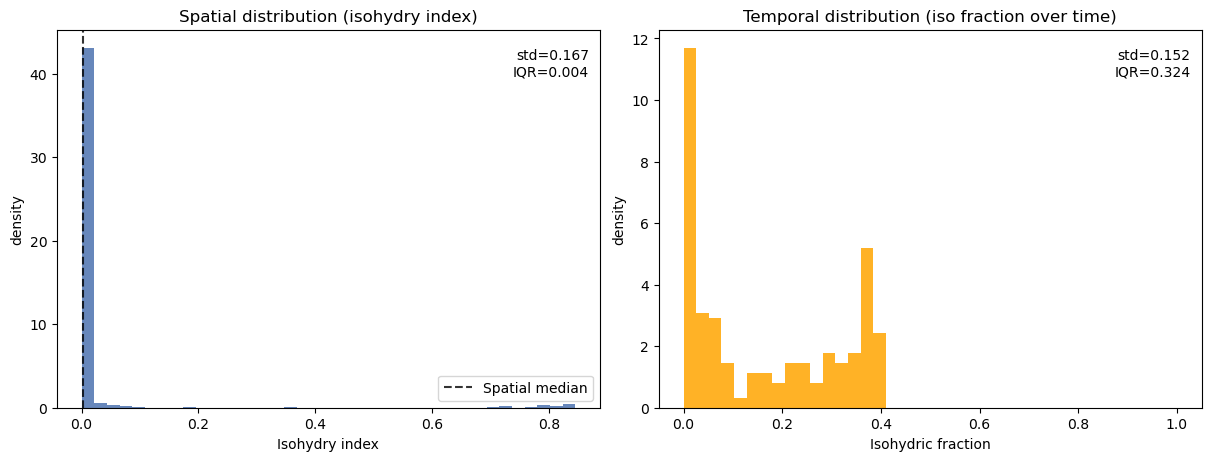


Width comparison (bigger = wider spread)
  Spatial:  std=0.167, IQR=0.004
  Temporal: std=0.152, IQR=0.324
  Wider by std: Spatial
  Wider by IQR: Temporal

Spatial (innate) shares using median threshold:
  Isohydric strategies:   0.500
  Anisohydric strategies: 0.500

Temporal (behavioral) shares across time:
  Mean fraction acting isohydric over time:   0.163
  Mean fraction acting anisohydric over time: 0.837


In [12]:
# Fake OWUS posterior -> ESS -> Iso/Aniso distributions within a pixel
# ---------------------------------------------------------------
# - Strategy: x = (fww, s_star, s_w)
# - OWUS stress: piecewise β(s)
# - Environment: single canonical soil moisture PDF p_s(s) (Beta), no microsites
# - Fitness: F̄(s_w) = E_s[β(s)] - λ Var_s[β(s)] averaged over posterior (for speed),
#   then replicator dynamics -> ESS mixture p*
# - Iso/Aniso classification: by "isohydry index" = fww / (s_star - s_w)
#   (steeper slope on the ramp => more isohydric); median split for fake data

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(2026)

# ------------------------------------------------------------
# 1) Fake OWUS posterior = innate spatial variability
# ------------------------------------------------------------
N = 400  # number of individuals/strategies in the pixel
fww   = np.clip(rng.normal(0.60, 0.07, N), 0.30, 0.95)
sstar = np.clip(rng.normal(0.45, 0.08, N), 0.18, 0.85)
sw    = np.clip(rng.normal(0.27, 0.08, N), 0.02, 0.58)
sw    = np.minimum(sw, sstar - 1e-3)   # enforce sw < s*

# Isohydry index (innate tendency): bigger = steeper ramp => more isohydric
iso_index = fww / np.maximum(sstar - sw, 1e-9)
thr_iso   = np.median(iso_index)  # median split to define "iso" vs "aniso" classes

is_iso_trait  = iso_index >= thr_iso
is_aniso_trait= ~is_iso_trait

# ------------------------------------------------------------
# 2) Environment time series (temporal variability)
#    Drydown -> storm -> drydown; plus seasonal E0(t)
# ------------------------------------------------------------
T = 240
t = np.arange(T)

s = np.empty(T, float)
# Initial wet state
s0 = 0.62
# Drydown 1
s[:100] = np.clip(s0 - 0.0032*np.arange(100), 0.01, 0.99)
# Storm pulse
s[100] = np.clip(s[99] + 0.22, 0.0, 0.99)
# Drydown 2 (a bit faster)
s[101:] = np.clip(s[100] - 0.0042*np.arange(1, T-100), 0.01, 0.99)

E0 = 2.0e-3 + 9e-4*np.sin(2*np.pi*(t/T)) + rng.normal(0, 1.2e-4, T)
E0 = np.clip(E0, 2e-4, None)

# ------------------------------------------------------------
# 3) Acting isohydry through time
#    A strategy "acts isohydric" at time t if:
#      - s_w < s_t <= s_star   (in its ramp, i.e., actively regulating)
#      - its isohydry index >= median threshold (more isohydric tendency)
# ------------------------------------------------------------
def in_ramp(s_t, sw_i, sstar_i):
    return (s_t > sw_i) & (s_t <= sstar_i)

acting_iso_fraction = np.zeros(T)
acting_aniso_fraction = np.zeros(T)

for k in range(T):
    s_t = s[k]
    active = in_ramp(s_t, sw, sstar)  # strategies engaged in regulation at this s_t
    if not np.any(active):
        acting_iso_fraction[k] = 0.0
        acting_aniso_fraction[k] = 0.0
        continue
    # among active strategies, which have above-threshold isohydry index?
    iso_now   = active & is_iso_trait
    aniso_now = active & is_aniso_trait
    denom = active.sum()
    acting_iso_fraction[k]   = iso_now.sum()   / denom
    acting_aniso_fraction[k] = aniso_now.sum() / denom

# ------------------------------------------------------------
# 4) Compare widths:
#    - Spatial: distribution of iso_index across individuals (time-invariant).
#    - Temporal: distribution over time of acting_iso_fraction (time series).
# ------------------------------------------------------------
def iqr(x):
    q1, q3 = np.percentile(x, [25, 75])
    return q3 - q1

spatial_std = np.std(iso_index)
spatial_iqr = iqr(iso_index)

temporal_std = np.std(acting_iso_fraction)
temporal_iqr = iqr(acting_iso_fraction)

print("Width comparison (bigger = wider spread)")
print(f"  Spatial iso-index:    std={spatial_std:.3f}, IQR={spatial_iqr:.3f}")
print(f"  Temporal iso-fraction: std={temporal_std:.3f}, IQR={temporal_iqr:.3f}")
if temporal_std > spatial_std:
    print("  ==> Temporal distribution is wider by std.")
else:
    print("  ==> Spatial distribution is wider by std.")
if temporal_iqr > spatial_iqr:
    print("  ==> Temporal distribution is wider by IQR.")
else:
    print("  ==> Spatial distribution is wider by IQR.")

# ------------------------------------------------------------
# 5) Plots
# ------------------------------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(9, 11), constrained_layout=True, sharex=False)

# (A) Environment
axs[0].plot(t, s, label="soil saturation s(t)")
axs[0].set_ylabel("s (0–1)")
axs[0].set_title("Environmental time series")
axs0b = axs[0].twinx()
axs0b.plot(t, E0, label="E0(t)", alpha=0.5, linestyle="--")
axs0b.set_ylabel("E0 (arb. units)")
axs[0].legend(loc="upper right")

# (B) Spatial (innate) distribution of isohydry index
bins = np.linspace(np.percentile(iso_index, 1), np.percentile(iso_index, 99), 40)
axs[1].hist(iso_index, bins=bins, alpha=0.8, color="#4c72b0")
axs[1].axvline(thr_iso, color="k", linestyle="--", alpha=0.8, label="median threshold")
axs[1].set_xlabel("Isohydry index  fww / (s* - sw)")
axs[1].set_ylabel("count")
axs[1].set_title("SPATIAL: strategy distribution (across individuals)")
axs[1].legend()

# (C) Temporal fraction acting isohydric
axs[2].plot(t, acting_iso_fraction, label="fraction acting isohydric", linewidth=2)
axs[2].plot(t, acting_aniso_fraction, label="fraction acting anisohydric", linewidth=2, alpha=0.7)
axs[2].set_ylim(0, 1)
axs[2].set_ylabel("fraction")
axs[2].set_title("TEMPORAL: fraction acting iso/aniso over time")
axs[2].legend()

plt.show()

# (D) Distributions side-by-side (spatial vs temporal)
#     - Spatial: histogram of iso_index (normalized)
#     - Temporal: histogram of acting_iso_fraction across t (normalized)
# Plot spatial and temporal distributions on separate x-scales
def normalize_to_unit(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-12)

def iqr(x):
    q1, q3 = np.percentile(x, [25, 75])
    return q3 - q1

spatial_vals  = normalize_to_unit(iso_index) # normalize
thr_iso_norm   = np.median(spatial_vals) 
temporal_vals = acting_iso_fraction

bins_s = np.linspace(np.percentile(spatial_vals, 1), np.percentile(spatial_vals, 99), 40)
bins_t = np.linspace(0, 1, 40)

fig2, ax = plt.subplots(1, 2, figsize=(12, 4.5), constrained_layout=True)

# Spatial
ax[0].hist(spatial_vals, bins=bins_s, density=True, alpha=0.85, color="#4c72b0")
ax[0].axvline(thr_iso_norm, color="k", linestyle="--", alpha=0.8, label="Spatial median")
ax[0].set_title("Spatial distribution (isohydry index)")
ax[0].set_xlabel("Isohydry index")
ax[0].set_ylabel("density")
s_std, s_iqr = np.std(spatial_vals), iqr(spatial_vals)
ax[0].text(0.98, 0.95, f"std={s_std:.3f}\nIQR={s_iqr:.3f}",
           transform=ax[0].transAxes, ha="right", va="top",
           bbox=dict(fc="white", ec="none", alpha=0.85))
ax[0].legend()

# Temporal
ax[1].hist(temporal_vals, bins=bins_t, density=True, alpha=0.85, color="orange")
ax[1].set_title("Temporal distribution (iso fraction over time)")
ax[1].set_xlabel("Isohydric fraction")
ax[1].set_ylabel("density")
t_std, t_iqr = np.std(temporal_vals), iqr(temporal_vals)
ax[1].text(0.98, 0.95, f"std={t_std:.3f}\nIQR={t_iqr:.3f}",
           transform=ax[1].transAxes, ha="right", va="top",
           bbox=dict(fc="white", ec="none", alpha=0.85))

plt.show()

# Optional: print a quick verdict
print("\nWidth comparison (bigger = wider spread)")
print(f"  Spatial:  std={s_std:.3f}, IQR={s_iqr:.3f}")
print(f"  Temporal: std={t_std:.3f}, IQR={t_iqr:.3f}")
print("  Wider by std:", "Temporal" if t_std > s_std else "Spatial")
print("  Wider by IQR:", "Temporal" if t_iqr > s_iqr else "Spatial")

# ------------------------------------------------------------
# 6) Text summary (also print group shares)
# ------------------------------------------------------------
spatial_iso_share = is_iso_trait.mean()
print("\nSpatial (innate) shares using median threshold:")
print(f"  Isohydric strategies:   {spatial_iso_share:.3f}")
print(f"  Anisohydric strategies: {1 - spatial_iso_share:.3f}")

time_weighted_iso_share = acting_iso_fraction.mean()
print("\nTemporal (behavioral) shares across time:")
print(f"  Mean fraction acting isohydric over time:   {time_weighted_iso_share:.3f}")
print(f"  Mean fraction acting anisohydric over time: {1 - time_weighted_iso_share:.3f}")



Within a representative pixel, the distribution of innate OWUS trait combinations (spatial diversity) was narrower than the distribution of isohydric behavior expressed through time under varying soil moisture (temporal diversity), indicating that environmental variability generates broader functional strategies than are evident from trait variation alone.